## Imports

In [4]:
# Standard library imports
import os
import random
import pickle

# Data analysis packages
import numpy as np
import pandas as pd
from scipy.signal import correlate, correlation_lags
from scipy.ndimage import gaussian_filter1d
from scipy.stats import norm

# Visualization packages
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import FancyArrow, Patch, Circle
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.lines import Line2D
from matplotlib.patches import FancyArrowPatch

# Image processing packages
import imageio
from PIL import Image, ImageSequence

# Braingeneers packages for analysis
import braingeneers
import braingeneers.data.datasets_electrophysiology as ephys
from braingeneers.analysis.analysis import SpikeData, read_phy_files, load_spike_data, burst_detection, randomize_raster

import diptest

import pickle

from matplotlib.ticker import MaxNLocator

## Helper Function

In [5]:
# Function to get neuron positions
def get_neuron_positions(spike_data):
    # Extract neuron positions from spike_data
    neuron_x = []
    neuron_y = []
    for neuron in spike_data.neuron_data['positions'].values():
        neuron_x.append(neuron['position'][0])
        neuron_y.append(neuron['position'][1])
    neuron_positions = np.array([neuron_x, neuron_y]).T
    return neuron_positions

def calculate_mean_firing_rates(spike_data):
    mean_firing_rates = []
    for neuron_spikes in spike_data.train:
        num_spikes = len(neuron_spikes)
        time_duration = spike_data.length / 1000  # Assuming spike times are in milliseconds
        firing_rate = num_spikes / time_duration
        mean_firing_rates.append(firing_rate)

    return np.array(mean_firing_rates)

def load_from_pickle(file_path):
    """
    Load and return the Python object from a pickle file.
    
    Parameters:
    - file_path: str, the path to the pickle file to be loaded.
    
    Returns:
    - The Python object loaded from the pickle file.
    """
    try:
        with open(file_path, 'rb') as file:
            return pickle.load(file)
    except FileNotFoundError:
        print(f"Error: The file {file_path} was not found.")
    except Exception as e:
        print(f"An error occurred while loading the pickle file: {e}")

def plot_raster(sd):
    idces, times = sd.idces_times()
    # Adjust the figsize parameter to change the figure size; (width, height) in inches
    fig, ax = plt.subplots(figsize=(10, 6))  # Example: 10 inches wide by 6 inches tall

    ax.scatter(times/1000, idces, marker='|', s=1)
    ax.set_xlabel("Time(s)")
    ax.set_ylabel('Unit #')
    plt.show()

def firing_plotter(sd, global_min_rate, global_max_rate):
    # Custom colormap from pale red/pink to dark red/black
    colors = ["#ffcccb", "#ff6961", "#ff5c5c", "#ff1c00", "#bf0000", "#800000", "#400000", "#000000"]
    cmap_name = "custom_red_black"
    n_bins = 100  # More bins will give us a finer gradient
    cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

    firing_rates = calculate_mean_firing_rates(sd)
    neuron_x, neuron_y = [], []
    # Extract neuron positions
    for i, neuron in sd.neuron_data['positions'].items():
        neuron_x.append(neuron['position'][0])
        neuron_y.append(neuron['position'][1])

    plt.figure(figsize=(8, 6))
    # Plotting a small pale blue square at each neuron position
    plt.scatter(neuron_x, neuron_y, s=10, c='#add8e6', marker='s', alpha=0.6)
    scatter = plt.scatter(neuron_x, neuron_y, s=firing_rates*1.5, c=firing_rates, alpha=0.6, cmap=cm, vmin=global_min_rate, vmax=75)

    # Creating dummy plots for the legend
    for rate in [20, 40, 60]:  # Example firing rates
        plt.scatter([], [], s=rate*1.5, c='gray', alpha=0.6, label=f'{rate} Hz')

    plt.title("Animation of Firing Rates for Synthetic Wave-Propagation Data")
    plt.xlabel("X Position")
    plt.ylabel("Y Position")
    plt.colorbar(scatter, label='Firing Rate (Hz)')
    plt.gca().invert_yaxis()

    # Adding the legend for sizes with title
    plt.legend(scatterpoints=1, frameon=False, labelspacing=1, title='Firing Rate', loc='upper right')

    # plt.show()

def unpickle_object(filename):
    """
    Deserializes and returns an object from a file using the pickle protocol.

    Parameters:
    - filename: The name of the file from which the object will be loaded.

    Returns:
    - The Python object deserialized from the file.
    """
    with open(filename, 'rb') as file:
        obj = pickle.load(file)
    return obj

def position_to_grid(pos):
    # Modify this function based on your grid conversion logic
    return pos[0], pos[1]  # Example conversion

def transform_neuron_data(sd):
    original_data = sd.neuron_data
    transformed_neuron_data = {'positions': {}}

    for top_level_key, clusters in original_data.items():
        for cluster_id, cluster_info in clusters.items():
            grid_pos = position_to_grid(cluster_info['position'])
            transformed_neuron_data['positions'][cluster_id] = {'position': grid_pos}

    return SpikeData(train=sd.train, length=sd.length, neuron_data=transformed_neuron_data)

## Code to implement spatial activity profile method

### Helper functions

In [6]:
def precalculate_distances_angles(neuron_positions):
    # Vectorized calculation of distances
    diff = neuron_positions[:, np.newaxis, :] - neuron_positions[np.newaxis, :, :]
    distances = np.sqrt(np.sum(diff**2, axis=2))
    
    # Vectorized calculation of angles
    angles = np.arctan2(diff[..., 1], diff[..., 0]) % (2 * np.pi)
    
    return distances, angles


def create_reverse_rank_lookup(event_ranks):
    """
    Create a reverse lookup table for event ranks.
    
    Parameters:
    - event_ranks: A dictionary mapping (neuron_id, spike_time) to event rank.
    
    Returns:
    - A dictionary mapping event rank to (neuron_id, spike_time).
    """
    reverse_lookup = {rank: (neuron_id, spike_time) for (neuron_id, spike_time), rank in event_ranks.items()}
    return reverse_lookup 

def calculate_event_ranks(spike_data, precision=5):
    # Flatten the list of spikes, rounding spike times, and sort by time
    # Include the original index of each spike for uniqueness
    all_spikes = [(neuron_id, round(spike_time, precision), idx) 
                  for neuron_id, spikes in enumerate(spike_data.train) 
                  for idx, spike_time in enumerate(spikes)]
                  
    # Sort by neuron_id, then rounded spike time, then original index
    all_spikes_sorted = sorted(all_spikes, key=lambda x: (x[1], x[0], x[2]))
    
    # Generate a dictionary with event rank as key, (neuron_id, spike_time) as value
    ranks = {rank: (neuron_id, spike_time) for rank, (neuron_id, spike_time, _) in enumerate(all_spikes_sorted)}
    
    print(f"Total unique events: {len(ranks)}")
    
    return ranks

def precompute_close_neurons(distances, window_size=17.5):
    # Initialize a dictionary to store the indices of close neurons for each neuron
    close_neurons = {}
    
    # Get the total number of neurons based on the distances matrix
    num_neurons = distances.shape[0]
    
    # Iterate over each neuron to find its close neighbors
    for i in range(num_neurons):
        # List comprehension to find neurons within the specified window size
        # Excludes the current neuron itself (i != j) and checks the distance condition
        close_neurons[i] = [
            j for j in range(num_neurons) 
            if i != j and distances[i, j] < window_size
        ]
        
    return close_neurons

def compute_bin_midpoints(bins):
    midpoints = (bins[:-1] + bins[1:]) / 2
    return midpoints

### Look at 30 events BEFORE

In [7]:
# Looking at 30 events BEFORE

def create_distance_angle_histograms_before(spike_data, event_ranks, spatial_range=(0, 500), rank_window=30, bins=6):
    total_events = len(event_ranks)
    histograms_per_event = {}

    distances, angles = precalculate_distances_angles(get_neuron_positions(spike_data))
    
    distance_bins = np.linspace(spatial_range[0], spatial_range[1], bins+1)
    angle_bins = np.linspace(0, 2*np.pi, bins+1, endpoint=True)

    print_every_n = max(total_events // 10, 1)

    for current_event_id in event_ranks:
        if current_event_id % print_every_n == 0:
            print(f"Processing event {current_event_id} of {total_events}")

        start_rank = max(0, current_event_id - rank_window)
        end_rank = current_event_id

        event_distances = []
        event_angles = []

        # Only consider events within the rank window
        for other_event_id in range(start_rank, end_rank):
            if other_event_id == current_event_id:
                continue
            
            current_neuron_id = event_ranks[current_event_id][0]
            other_neuron_id = event_ranks[other_event_id][0]

            # Lookup distance and angle between the two neurons
            distance = distances[current_neuron_id, other_neuron_id]
            # print("Distance: ", distance)
            angle = angles[current_neuron_id, other_neuron_id]
            # print("Angle: ", angle)

            if np.abs(distance) < spatial_range[1]:
                event_distances.append(distance)
                event_angles.append(angle)
            
        event_angles = [0 if angle == 2*np.pi else angle for angle in event_angles]

        distance_hist, _ = np.histogram(event_distances, bins=distance_bins)
        angle_hist, _ = np.histogram(event_angles, bins=angle_bins)

        histograms_per_event[current_event_id] = {'distance': distance_hist, 'angle': angle_hist}

    print("Processing complete")
    return histograms_per_event

### Look at 30 events AFTER

In [8]:
# Looking at 30 events AFTER

def create_distance_angle_histograms_after(spike_data, event_ranks, spatial_range=(0, 500), rank_window=30, bins=6):
    total_events = len(event_ranks)
    histograms_per_event = {}

    distances, angles = precalculate_distances_angles(get_neuron_positions(spike_data))
    
    distance_bins = np.linspace(spatial_range[0], spatial_range[1], bins+1)
    angle_bins = np.linspace(0, 2*np.pi, bins+1, endpoint=True)

    print_every_n = max(total_events // 10, 1)

    for current_event_id in event_ranks:
        if current_event_id % print_every_n == 0:
            print(f"Processing event {current_event_id} of {total_events}")

        # Adjust the rank window to look at events after the current event
        start_rank = current_event_id + 1  # Start from the next event
        end_rank = min(total_events, current_event_id + rank_window + 1)  # Ensure not to exceed the total events

        event_distances = []
        event_angles = []

        # Only consider events within the rank window
        for other_event_id in range(start_rank, end_rank):
            current_neuron_id = event_ranks[current_event_id][0]
            other_neuron_id = event_ranks[other_event_id][0]

            # Lookup distance and angle between the two neurons
            distance = distances[current_neuron_id, other_neuron_id]
            angle = angles[current_neuron_id, other_neuron_id]

            if np.abs(distance) < spatial_range[1]:
                event_distances.append(distance)
                event_angles.append(angle)
            
        event_angles = [0 if angle == 2*np.pi else angle for angle in event_angles]

        distance_hist, _ = np.histogram(event_distances, bins=distance_bins)
        angle_hist, _ = np.histogram(event_angles, bins=angle_bins)

        histograms_per_event[current_event_id] = {'distance': distance_hist, 'angle': angle_hist}

    print("Processing complete")
    return histograms_per_event

### Other processing

In [9]:
def compute_average_angle_from_histogram(angle_hist):
    # Check if the histogram sum is zero
    if np.sum(angle_hist) == 0:
        # Handle the case where the histogram sum is zero
        # For example, return None or raise an error
        return np.nan  # or consider raising an error or returning a default value

    bin_width = 360 / len(angle_hist)
    bin_midpoints = np.arange(0, 360, bin_width) + bin_width / 2
    bin_midpoints_radians = np.radians(bin_midpoints)

    x_components = angle_hist * np.cos(bin_midpoints_radians)
    y_components = angle_hist * np.sin(bin_midpoints_radians)

    x_mean = np.sum(x_components) / np.sum(angle_hist)
    y_mean = np.sum(y_components) / np.sum(angle_hist)

    # Compute the arctangent of the mean vector components to get the average angle in radians
    average_angle_radians = np.arctan2(y_mean, x_mean)

    # Normalize the average angle to be within 0 to 2*pi radians
    if average_angle_radians < 0:
        average_angle_radians += 2 * np.pi

    # Return the average angle in radians
    return average_angle_radians


# Function to take final histograms and calculate the average distance and angle for each event
def compute_average_distance_angle(final_histograms, spatial_range=(0, 10), bins=6):
    average_distances_angles = {}

    distance_midpoints = compute_bin_midpoints(np.linspace(spatial_range[0], spatial_range[1], bins+1))
    angle_midpoints = compute_bin_midpoints(np.linspace(0, 2*np.pi, bins+1))

    angle_midpoints_degrees = np.degrees(angle_midpoints)

    # print(angle_midpoints_degrees)

    for event_id, histograms in final_histograms.items():
        distance_hist = histograms['distance']
        angle_hist = histograms['angle']

        # Compute average distance
        distance_sum = np.sum(distance_hist * distance_midpoints)
        distance_count = np.sum(distance_hist)
        average_distance = distance_sum / distance_count if distance_count != 0 else 0

        # Compute average angle
        average_angle = compute_average_angle_from_histogram(angle_hist)

        normalized_average_angle = average_angle % (2 * np.pi)

        average_distances_angles[event_id] = {'distance': average_distance, 'angle': average_angle}

    return average_distances_angles

def all_events_per_neuron(spike_data, average_distances_angles_per_event):
    all_events_per_neuron = {}

    event_ranks = calculate_event_ranks(spike_data)
    for event_id, averages in average_distances_angles_per_event.items():
        neuron_id = event_ranks[event_id][0]
        if neuron_id not in all_events_per_neuron:
            all_events_per_neuron[neuron_id] = []
        all_events_per_neuron[neuron_id].append(averages)

    return all_events_per_neuron

def average_events_per_neuron(spike_data, average_distances_angles_per_event):
    events_per_neuron = all_events_per_neuron(spike_data, average_distances_angles_per_event)
    positions = get_neuron_positions(spike_data)

    average_events_per_neuron = {}
    for neuron_id, events in events_per_neuron.items():
        angles = [event['angle'] for event in events]
        distances = [event['distance'] for event in events]

        # Calculate vector components
        x_components = [distance * np.cos(angle) for distance, angle in zip(distances, angles)]
        y_components = [distance * np.sin(angle) for distance, angle in zip(distances, angles)]

        # Calculate average vector components
        x_mean = np.mean(x_components)
        y_mean = np.mean(y_components)

        # Convert average vector components to polar coordinates
        average_distance = np.sqrt(x_mean**2 + y_mean**2)
        average_angle = np.arctan2(y_mean, x_mean)

        # # Normalize the average angle to be within 0 to 2*pi radians
        # if average_angle < 0:
        #     average_angle += 2 * np.pi

        average_events_per_neuron[neuron_id] = {'distance': average_distance, 'angle': average_angle, 'position': positions[neuron_id]}

    return average_events_per_neuron

## PLOTTER

In [11]:
def plot_data(data, title):
    """
    Plots data points with arrows indicating direction and distance.
    Points with 'nan' angles are skipped in arrow plotting.

    Parameters:
    - data: A dictionary where each key is an identifier and each value is a dictionary
            containing 'distance', 'angle', and 'position'.
    """
    # Adjusting the plot with specified modifications: narrower, less bold arrows, and red neurons
    fig, ax = plt.subplots(figsize=(12, 8))  # Increased figure size for better visibility
    for key, value in data.items():
        position = np.array(value['position'])  # Ensure position is a numpy array
        angle = value['angle']
        distance = value['distance'] # Scaling down the distance for better visualization

        # Plotting the point in red
        ax.plot(position[0], position[1], 'o', color='red')

        # Skip plotting the arrow if angle is nan
        if not np.isnan(angle):
            # Calculate the end point of the arrow
            end_point = position - np.array([np.cos(angle) * distance, np.sin(angle) * distance])
            
            # Plotting the arrow with narrower and less bold appearance
            ax.annotate('', xy=end_point, xytext=position,
                        arrowprops=dict(facecolor='black', shrink=0.05, width=0.5, headwidth=5, headlength=5))

    ax.set_aspect('equal')
    # Invert y axis
    ax.invert_yaxis()
    ax.set_title(title)
    plt.show()

## Data

In [12]:
from human_hip import spike_data

hc_328 = read_phy_files('/workspaces/human_hippocampus/data/ephys/2023-04-02-e-hc328_unperturbed/derived/kilosort2/hc3.28_hckcr1_chip16835_plated34.2_rec4.2_curated_s1.zip')
hc_52 = read_phy_files('/workspaces/human_hippocampus/data/ephys/2023-05-10-e-hc52_18790_unperturbed/derived/kilosort2/hc5.2_chip18790_baseline_rec5.10.23_curated_s1.zip')
hc_111 = read_phy_files('/workspaces/human_hippocampus/data/ephys/2022-11-02-e-Hc11.1-chip16753/derived/kilosort2/hc11.1_plated-11.1_chip-16753_rec_11.2.22AM-immediate_curated.zip')
hc_112823 = spike_data.read_autocurated_data('/workspaces/human_hippocampus/data/ephys/2023-12-03-e-Hc112823_avv9hckcr1/derived/kilosort2/Hc112723_hckcr1_21841_120323_base_acqm.zip')
hc_112823_2 = spike_data.read_autocurated_data('/workspaces/human_hippocampus/data/ephys/2023-12-03-e-Hc112823_avv9hckcr1/derived/kilosort2/Hc112723_hckcr1_21841_120323_base2_acqm.zip')
hc_120523_chip21769 = read_phy_files("/workspaces/human_hippocampus/data/ephys/2023-12-11-e-Hc120523_aav9hckcr1_chip21769/elliott/elliott_chip21769_base.zip")

hc_328 = transform_neuron_data(hc_328)
hc_52 = transform_neuron_data(hc_52)
hc_111 = transform_neuron_data(hc_111)
hc_112823 = transform_neuron_data(hc_112823)
hc_112823_2 = transform_neuron_data(hc_112823_2)
hc_120523_chip21769 = transform_neuron_data(hc_120523_chip21769)

/tmp/ipykernel_24922/3302845650.py:3: DeprecationWarning: Call to deprecated function (or staticmethod) read_phy_files. (Prefer load_spike_data()) -- Deprecated since version 0.1.13.
  hc_328 = read_phy_files('/workspaces/human_hippocampus/data/ephys/2023-04-02-e-hc328_unperturbed/derived/kilosort2/hc3.28_hckcr1_chip16835_plated34.2_rec4.2_curated_s1.zip')
/tmp/ipykernel_24922/3302845650.py:4: DeprecationWarning: Call to deprecated function (or staticmethod) read_phy_files. (Prefer load_spike_data()) -- Deprecated since version 0.1.13.
  hc_52 = read_phy_files('/workspaces/human_hippocampus/data/ephys/2023-05-10-e-hc52_18790_unperturbed/derived/kilosort2/hc5.2_chip18790_baseline_rec5.10.23_curated_s1.zip')
/tmp/ipykernel_24922/3302845650.py:5: DeprecationWarning: Call to deprecated function (or staticmethod) read_phy_files. (Prefer load_spike_data()) -- Deprecated since version 0.1.13.
  hc_111 = read_phy_files('/workspaces/human_hippocampus/data/ephys/2022-11-02-e-Hc11.1-chip16753/der

In [14]:
def analyze_spike_data(spikedata, spatial_range=(0, 50), rank_window=500, bins=6):
    """
    Analyzes spike data to compute histograms and averages before and after certain events.

    Parameters:
    - spikedata: The spike data to analyze.
    - spatial_range: A tuple defining the spatial range to consider.
    - rank_window: The rank window size for event calculation. Default is 500.
    - bins: The number of bins for histograms. Default is 6.

    Returns:
    A dictionary containing the before and after averages for distances, angles, and events per neuron.
    """
    # Calculate event ranks
    event_ranks = calculate_event_ranks(spikedata)
    
    # Create histograms
    before_histograms = create_distance_angle_histograms_before(spikedata, event_ranks, spatial_range=spatial_range, rank_window=rank_window, bins=bins)
    after_histograms = create_distance_angle_histograms_after(spikedata, event_ranks, spatial_range=spatial_range, rank_window=rank_window, bins=bins)
    
    # Compute averages
    before_average_distances_angles = compute_average_distance_angle(before_histograms, spatial_range=spatial_range, bins=bins)
    after_average_distances_angles = compute_average_distance_angle(after_histograms, spatial_range=spatial_range, bins=bins)
    
    # Average events per neuron
    before_average_events_per_neuron = average_events_per_neuron(spikedata, before_average_distances_angles)
    after_average_events_per_neuron = average_events_per_neuron(spikedata, after_average_distances_angles)
    
    return before_average_events_per_neuron, after_average_events_per_neuron

In [103]:
def calculate_overall_stats(datasets):
    # Initialize list to hold data for DataFrame
    data_for_df = []
    
    # Loop over each dataset
    for dataset_name, dataset in datasets.items():
        # Calculate overall mean firing rate
        mean_firing_rate = np.mean(calculate_mean_firing_rates(dataset))
        
        # Calculate mean distance between all neuron pairs
        neuron_positions = get_neuron_positions(dataset)
        distances, angles = precalculate_distances_angles(neuron_positions)
        mean_distance = np.mean(distances)
        
        # Append the dataset name, mean firing rate, and mean distance to the list
        data_for_df.append([dataset_name, mean_firing_rate, mean_distance])
    
    # Create DataFrame
    df = pd.DataFrame(data_for_df, columns=['Dataset', 'Mean Firing Rate', 'Mean Distance'])
    return df

def mean_median_isi(spike_data):
    """
    Calculate the mean of the median interspike intervals (ISIs) for each unit in the spike_data.

    :param spike_data: An object containing spike train data, which has a method interspike_intervals() returning a list of arrays of ISIs for each unit.
    :return: The mean of the median ISIs across all units.
    """
    # Get the list of arrays of ISIs for each unit
    isi_list = spike_data.interspike_intervals()

    # Calculate the median ISI for each unit and store them in a list
    median_isi_list = [np.median(isi) for isi in isi_list if len(isi) > 0]

    # Calculate the mean of the median ISIs
    mean_median_isi = np.mean(median_isi_list) if median_isi_list else 0

    return mean_median_isi

def median_distance(neuron_positions):
    """
    Calculate the median distance between all pairs of neurons.

    :param neuron_positions: An array of shape (n_neurons, 2) containing the x and y coordinates of the neurons.
    :return: The median distance between all neuron pairs.
    """
    # Calculate the distances between all pairs of neurons
    distances, _ = precalculate_distances_angles(neuron_positions)

    # Use only the upper triangular part of the distance matrix, excluding the diagonal
    upper_tri_distances = distances[np.triu_indices(distances.shape[0], k=1)]

    # Calculate and return the median of these distances
    median_dist = np.median(upper_tri_distances)
    return median_dist

def mean_distances(neuron_positions):
    """
    Calculate the mean distance between all pairs of neurons.

    :param neuron_positions: An array of shape (n_neurons, 2) containing the x and y coordinates of the neurons.
    :return: The mean distance between all neuron pairs.
    """
    # Calculate the distances between all pairs of neurons
    distances, _ = precalculate_distances_angles(neuron_positions)

    # Use only the upper triangular part of the distance matrix, excluding the diagonal
    upper_tri_distances = distances[np.triu_indices(distances.shape[0], k=1)]

    # Calculate and return the mean of these distances
    mean_dist = np.mean(upper_tri_distances)
    return mean_dist

In [142]:
datasets = {
    "HC_328": hc_328,
    "HC_52": hc_52,
    "HC_111": hc_111,
    "HC_112823": hc_112823,
    "HC_112823_2": hc_112823_2,
    "HC_120523": hc_120523_chip21769
}


In [143]:
def create_df(datasets):
    """
    Create a DataFrame containing the median distance and mean median ISI for each dataset.

    :param datasets: A dictionary where keys are dataset names and values are SpikeData objects.
    :return: A DataFrame with columns 'Dataset', 'Median Distance', and 'Mean Median ISI'.
    """
    # Initialize lists to store data for DataFrame
    data_for_df = []

    # Loop over each dataset
    for dataset_name, dataset in datasets.items():
        # Get the neuron positions
        neuron_positions = get_neuron_positions(dataset)

        # Calculate the median distance between all neuron pairs
        median_dist = median_distance(neuron_positions)

        # Calculate the mean of the median ISIs for each unit
        mean_median_isi_val = mean_median_isi(dataset)

        # Mean distance between all pairs of neurons
        mean_dist = mean_distances(neuron_positions)

        # Append the dataset name, median distance, and mean median ISI to the list
        data_for_df.append([dataset_name, median_dist, mean_median_isi_val, int(median_dist/3.2), int(750/np.sqrt(mean_median_isi_val)), int(median_dist/4), mean_dist])

    # Create the DataFrame
    df = pd.DataFrame(data_for_df, columns=['Dataset', 'Median Distance', 'Mean Median ISI', 'Spatial Bound', 'Rank Window', 'Spatial Bound2', 'Mean Distances'])
    return df

In [145]:
parameters = create_df(datasets)

/tmp/ipykernel_24922/2876065909.py:6: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  for neuron in spike_data.neuron_data['positions'].values():


In [146]:
parameters

,Dataset,Median Distance,Mean Median ISI,Spatial Bound,Rank Window,Spatial Bound2,Mean Distances
0,HC_328,560.273371,599.225368,175,30,140,639.314740
1,HC_52,687.640895,1650.964000,214,18,171,790.283865
2,HC_111,586.706911,1531.327874,183,19,146,642.185376
3,HC_112823,409.664497,681.231225,128,28,102,478.257137
4,HC_112823_2,409.664497,1249.273504,128,21,102,468.767581
5,HC_120523,315.485737,537.614706,98,32,78,419.632867


In [147]:
# Analyze spike data for each dataset, using upper bound of parameters spatial bound, and rank window of rank window in parameters

hc_328_data = analyze_spike_data(hc_328, spatial_range=(0, parameters.loc[0, 'Spatial Bound']), rank_window=parameters.loc[0, 'Rank Window'])
hc_52_data = analyze_spike_data(hc_52, spatial_range=(0, parameters.loc[1, 'Spatial Bound']), rank_window=parameters.loc[1, 'Rank Window'])
hc_111_data = analyze_spike_data(hc_111, spatial_range=(0, parameters.loc[2, 'Spatial Bound']), rank_window=parameters.loc[2, 'Rank Window'])
hc_112823_data = analyze_spike_data(hc_112823, spatial_range=(0, parameters.loc[3, 'Spatial Bound']), rank_window=parameters.loc[3, 'Rank Window'])
hc_112823_2_data = analyze_spike_data(hc_112823_2, spatial_range=(0, parameters.loc[4, 'Spatial Bound']), rank_window=parameters.loc[4, 'Rank Window'])
hc_120523_data = analyze_spike_data(hc_120523_chip21769, spatial_range=(0, parameters.loc[5, 'Spatial Bound']), rank_window=parameters.loc[5, 'Rank Window'])

# Analyze spike data for each dataset, using upper bound of parameters spatial bound, and rank window of rank window in parameters

# hc_328_data = analyze_spike_data(hc_328, spatial_range=(0, parameters.loc[0, 'Spatial Bound2']), rank_window=50)
# hc_52_data = analyze_spike_data(hc_52, spatial_range=(0, parameters.loc[1, 'Spatial Bound2']), rank_window=50)
# hc_111_data = analyze_spike_data(hc_111, spatial_range=(0, parameters.loc[2, 'Spatial Bound2']), rank_window=50)
# hc_112823_data = analyze_spike_data(hc_112823, spatial_range=(0, parameters.loc[3, 'Spatial Bound2']), rank_window=50)
# hc_112823_2_data = analyze_spike_data(hc_112823_2, spatial_range=(0, parameters.loc[4, 'Spatial Bound2']), rank_window=50)
# hc_120523_data = analyze_spike_data(hc_120523_chip21769, spatial_range=(0, parameters.loc[5, 'Spatial Bound2']), rank_window=50)

# # Analyze spike data for each dataset, using upper bound of parameters spatial bound, and rank window of rank window in parameters

# hc_328_data = analyze_spike_data(hc_328, spatial_range=(0, parameters2.loc[0, 'Spatial Bound2']), rank_window=30)
# hc_52_data = analyze_spike_data(hc_52, spatial_range=(0, parameters2.loc[1, 'Spatial Bound2']), rank_window=30)
# hc_111_data = analyze_spike_data(hc_111, spatial_range=(0, parameters2.loc[2, 'Spatial Bound2']), rank_window=30)
# hc_112823_data = analyze_spike_data(hc_112823, spatial_range=(0, parameters2.loc[3, 'Spatial Bound2']), rank_window=30)
# hc_112823_2_data = analyze_spike_data(hc_112823_2, spatial_range=(0, parameters2.loc[4, 'Spatial Bound2']), rank_window=30)
# hc_120523_data = analyze_spike_data(hc_120523_chip21769, spatial_range=(0, parameters2.loc[5, 'Spatial Bound2']), rank_window=30)

Total unique events: 103920
Processing event 0 of 103920


/tmp/ipykernel_24922/2876065909.py:6: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  for neuron in spike_data.neuron_data['positions'].values():


Processing event 10392 of 103920
Processing event 20784 of 103920
Processing event 31176 of 103920
Processing event 41568 of 103920
Processing event 51960 of 103920
Processing event 62352 of 103920
Processing event 72744 of 103920
Processing event 83136 of 103920
Processing event 93528 of 103920
Processing complete
Processing event 0 of 103920
Processing event 10392 of 103920
Processing event 20784 of 103920
Processing event 31176 of 103920
Processing event 41568 of 103920
Processing event 51960 of 103920
Processing event 62352 of 103920
Processing event 72744 of 103920
Processing event 83136 of 103920
Processing event 93528 of 103920
Processing complete
Total unique events: 103920
Total unique events: 103920
Total unique events: 21747
Processing event 0 of 21747
Processing event 2174 of 21747
Processing event 4348 of 21747
Processing event 6522 of 21747
Processing event 8696 of 21747
Processing event 10870 of 21747
Processing event 13044 of 21747
Processing event 15218 of 21747
Proces

In [89]:
# hc_328_data = analyze_spike_data(hc_328, spatial_range=(0, 200), rank_window=30, bins=6)
# hc_52_data = analyze_spike_data(hc_52, spatial_range=(0, 200), rank_window=20, bins=6)
# hc_111_data = analyze_spike_data(hc_111, spatial_range=(0, 200), rank_window=18, bins=6)
# hc_112823_data = analyze_spike_data(hc_112823, spatial_range=(0, 175), rank_window=20, bins=6)
# hc_112823_2_data = analyze_spike_data(hc_112823_2, spatial_range=(0, 150), rank_window=15, bins=6)
# hc_120523_chip21769_data = analyze_spike_data(hc_120523_chip21769, spatial_range=(0, 150), rank_window=20, bins=6)

In [ ]:
# hc_328_data = analyze_spike_data(hc_328, spatial_range=(0, 200), rank_window=30, bins=6)
# hc_52_data = analyze_spike_data(hc_52, spatial_range=(0, 200), rank_window=20, bins=6)
# hc_111_data = analyze_spike_data(hc_111, spatial_range=(0, 200), rank_window=18, bins=6)
# hc_112823_data = analyze_spike_data(hc_112823, spatial_range=(0, ), rank_window=20, bins=6)
# hc_112823_2_data = analyze_spike_data(hc_112823_2, spatial_range=(0, 150), rank_window=15, bins=6)
# hc_120523_chip21769_data = analyze_spike_data(hc_120523_chip21769, spatial_range=(0, 150), rank_window=20, bins=6)

In [134]:
def combined_arrow_plots(data_info):
    nrows, ncols = 6, 2
    fig, axs = plt.subplots(nrows, ncols, figsize=(8, 14))

    for idx, (data, title, is_rotated, x_window, y_window) in enumerate(data_info):
        ax = axs[idx // ncols, idx % ncols]

        # Determine neuron color based on column
        neuron_color = 'lightblue' if idx % ncols == 0 else 'red'

        # Prepare positions and optionally rotate
        positions = np.array([value['position'] for value in data.values()])
        if is_rotated:
            positions = positions[:, ::-1]  # Swap x and y for rotation
            angles = [value['angle'] + np.pi/2 for value in data.values()]
        else:
            angles = [value['angle'] for value in data.values()]

        # Plot neurons with the determined color
        ax.scatter(positions[:, 0], positions[:, 1], color=neuron_color, s=12)

        # Plot arrows
        for pos, angle, value in zip(positions, angles, data.values()):
            if np.isnan(angle): continue
            distance = value['distance']
            end_pos = pos - np.array([np.cos(angle) * distance, np.sin(angle) * distance])
            ax.annotate('', xy=end_pos, xytext=pos,
                        arrowprops=dict(facecolor='black', shrink=0.05, width=0.5, headwidth=5, headlength=5))

        ax.axis('equal')
        ax.set_xlim(x_window)
        ax.set_ylim(y_window)

        # Write dataset name to the left of the left plot in each row
        if idx % ncols == 0:  # This is a left column plot
            ax.text(-0.15, 0.5, title, transform=ax.transAxes, rotation=90, va='center', ha='right')

    # Label columns at the top
    axs[0, 0].set_title('Average Activity Before')
    axs[0, 1].set_title('Average Activity After')

    plt.tight_layout(pad=0.5)
    plt.savefig('Human_Data_Muthmann.png', dpi=300)
    plt.show()

In [148]:
# datasets = [hc_328_data[0], hc_328_data[1], hc_52_data[0], hc_52_data[1], hc_111_data[0], hc_111_data[1]]
# titles = ['HC 328 Before', 'HC 328 After', 'HC 52 Before', 'HC 52 After', 'HC 111 Before', 'HC 111 After']

# Example data_info format
# data_info = [
#     # (data, title, is_rotated) for each subplot
#     # Ensure 'data' is a dictionary where each key corresponds to a neuron and
#     # each value is a dict with 'position': (x, y), 'angle': angle_in_radians, 'distance': distance_of_arrow
#     (hc_328_data[0], 'HC 328 Before', True, (100, 1500), (0, 500)),
#     (hc_328_data[1], 'HC 328 After', True, (100, 1500), (0, 500)),
#     (hc_52_data[0], 'HC 52 Before', False, (100, 1500), (0, 500)),
#     (hc_52_data[1], 'HC 52 After', False, (100, 1500), (0, 500)),
#     (hc_111_data[0], 'HC 111 Before', False, (100, 1500), (0, 500)),
#     (hc_111_data[1], 'HC 111 After', False, (100, 1500), (0, 500))
# ]

data_info = [
    (hc_328_data[0], 'HC 328', True, (250, 1500), (1000, 1500)),
    (hc_328_data[1], 'HC 328 After', True, (250, 1500), (1000, 1500)),
    (hc_52_data[0], 'HC 52', False, (2250, 4000), (300, 1200)),
    (hc_52_data[1], 'HC 52 After', False, (2250, 4000), (300, 1200)),
    (hc_111_data[0], 'HC 111', False, (1800, 2700), (500, 1200)),
    (hc_111_data[1], 'HC 111 After', False, (1800, 2700), (500, 1200)),
    (hc_120523_data[0], 'HC 120523', False, (2600, 3100), (400, 900)),
    (hc_120523_data[1], 'HC 120523 After', False, (2500, 3100), (400, 900)),
    (hc_112823_data[0], 'HC 112823', False, (300, 1300), (800, 1300)),
    (hc_112823_data[1], 'HC 112823 After', False, (300, 1300), (800, 1300)),
    (hc_112823_2_data[0], 'HC 112823 2', False, (300, 1600), (800, 1500)),
    (hc_112823_2_data[1], 'HC 112823 2 After', False, (300, 1600), (800, 1500))
]


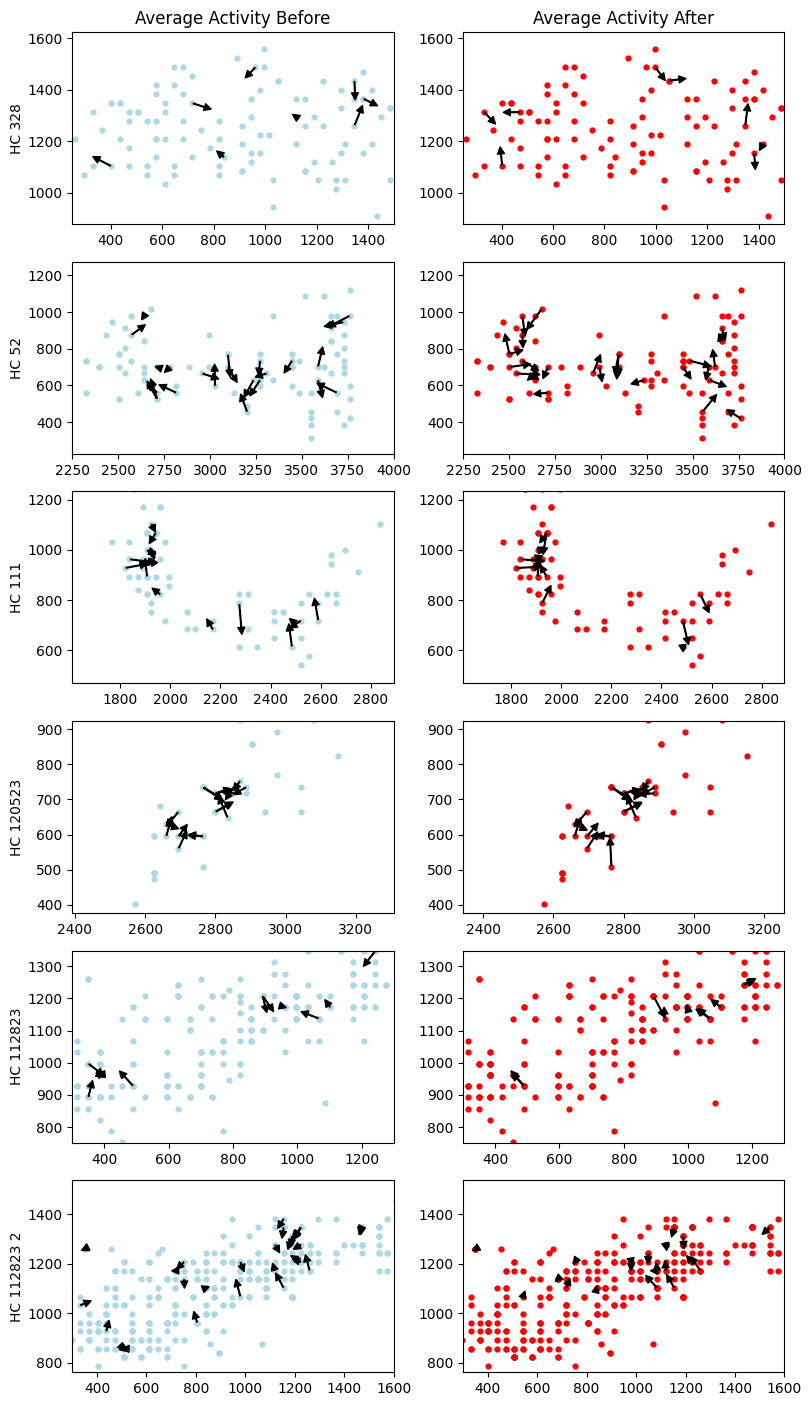

In [149]:
combined_arrow_plots(data_info)

In [150]:
def plot_combined_polar_histograms(datasets, num_bins=6):
    """
    Plots polar histograms of angles for each pair of datasets in 'datasets', arranged in a 2x3 grid.
    Each dataset pair's name is used as the title for its plot.
    The plots are line plots of the histogram data, with 0 degrees positioned at the horizontal x-axis going positive.
    The figure is 8 inches wide.

    Parameters:
    - datasets: A list of tuples, where each tuple contains two datasets followed by the dataset's name.
    - num_bins: Number of bins to use for the histogram.
    """
    fig_width = 8  # width in inches
    fig_height = fig_width / 3 * 2  # height calculated based on a 3x2 grid aspect ratio
    fig, axs = plt.subplots(2, 3, figsize=(fig_width, fig_height), subplot_kw={'polar': True})
    axs = axs.flatten()  # Flatten to make it easier to iterate over

    for idx, (data1, data2, name) in enumerate(datasets):
        ax = axs[idx]

        # Process each dataset and plot
        for data, color in [(data1, 'blue'), (data2, 'red')]:
            angles = np.array([entry['angle'] for entry in data.values() if not np.isnan(entry['angle'])])
            hist, bin_edges = np.histogram(angles, bins=num_bins, range=(-np.pi, np.pi))
            bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
            hist_closed = np.append(hist, hist[0])
            bin_centers_closed = np.append(bin_centers, bin_centers[0])

            # Plot the data
            # dashed lines for the first dataset, solid lines for the second dataset
            linestyle = '--' if color == 'red' else '-'
            ax.plot(bin_centers_closed, hist_closed, linestyle=linestyle, color=color, linewidth=2)

        # Set 0 degrees at the right (east) and direction clockwise
        ax.set_theta_zero_location('E')  # 'E' for east, which is the positive x-axis
        ax.set_theta_direction(-1)  # Clockwise direction

        ax.set_title(name)

        # Use MaxNLocator to ensure radius ticks are whole numbers
        ax.yaxis.set_major_locator(MaxNLocator(integer=True, nbins=3))

    # Add legend placed in whitespace below and between the bottom right plots
    custom_lines = [Line2D([0], [0], color='blue', linestyle='-', lw=2),
                    Line2D([0], [0], color='red', linestyle='--', lw=2)]
    
    fig.legend(custom_lines, ['Before', 'After'], loc='lower center', ncol=2)

    plt.tight_layout()
    plt.savefig('Human_Data_Muthmann_Polar.png', dpi=300)
    plt.show()

In [151]:
datasets = [
    [hc_328_data[0], hc_328_data[1], 'HC_328'],
    [hc_52_data[0], hc_52_data[1], 'HC_52'],
    [hc_111_data[0], hc_111_data[1], 'HC_111'],
    [hc_120523_data[0], hc_120523_data[1], 'HC_120523'],
    [hc_112823_data[0], hc_112823_data[1], 'HC_112823'],
    [hc_112823_2_data[0], hc_112823_2_data[1], 'HC_112823_2'],
]

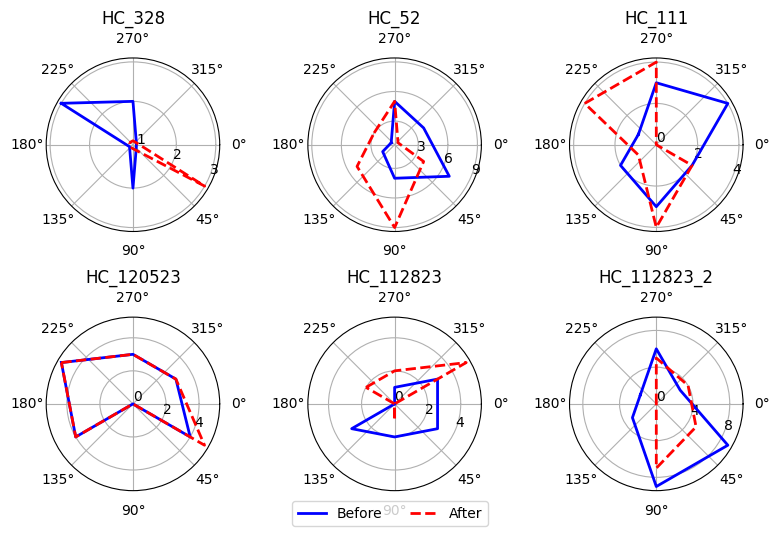

In [152]:
plot_combined_polar_histograms(datasets, num_bins=6)

In [83]:
hc_120523_data[0]

{22: {'distance': nan, 'angle': nan, 'position': array([2730.,  595.])},
 15: {'distance': nan, 'angle': nan, 'position': array([2887.5,  717.5])},
 25: {'distance': 44.930633280421304,
  'angle': 0.978627236017012,
  'position': array([2852.5,  735. ])},
 8: {'distance': 70.06627074456722,
  'angle': -1.1739262029046234,
  'position': array([2835. ,  647.5])},
 27: {'distance': 61.28539561250753,
  'angle': -1.8491486451593413,
  'position': array([2660.,  595.])},
 44: {'distance': 43.61678692407467,
  'angle': -0.11412324050794072,
  'position': array([2765.,  595.])},
 42: {'distance': nan, 'angle': nan, 'position': array([2905. ,  857.5])},
 10: {'distance': nan, 'angle': nan, 'position': array([2642.5,  682.5])},
 43: {'distance': 60.65559265995928,
  'angle': -2.634915919567172,
  'position': array([2800.,  665.])},
 24: {'distance': nan, 'angle': nan, 'position': array([2415.,  210.])},
 9: {'distance': 48.400051004483615,
  'angle': -2.852459867292429,
  'position': array([280

In [80]:
def calculate_proportion_with_data(dataset):
    count_with_data = 0  # Counter for entries with distance and angle data
    total_count = len(dataset)  # Total number of entries

    # Iterate through the dataset to check each entry
    for key, value in dataset.items():
        # Check if both 'distance' and 'angle' are not NaN
        if not np.isnan(value['distance']) and not np.isnan(value['angle']):
            count_with_data += 1

    # Calculate the proportion of entries with data
    proportion = count_with_data / total_count if total_count else 0
    return proportion * 100

In [85]:
# apply the function to each dataset, and the data[0] and data[1] sections for before and after and store results in a dataframe
proportions = pd.DataFrame({
    'Dataset': ['HC_328', 'HC_52', 'HC_111', 'HC_120523', 'HC_112823', 'HC_112823_2'],
    'Percentage Neurons with Vector in Before Plot': [calculate_proportion_with_data(data[0]) for data in datasets],
    'Percentage Neurons with Vector in After Plot': [calculate_proportion_with_data(data[1]) for data in datasets]
})

proportions

,Dataset,Percentage Neurons with Vector in Before Plot,Percentage Neurons with Vector in After Plot
0,HC_328,7.352941,5.882353
1,HC_52,23.000000,27.000000
2,HC_111,17.241379,17.241379
3,HC_120523,37.254902,39.215686
4,HC_112823,4.819277,4.016064
5,HC_112823_2,9.116809,5.982906


In [87]:
# add column for average distance of vectors in before and after plots
# add column for average angle in before and after plots using cartesian method to avoid issues

def calculate_average_distance(dataset):
    # Calculate the average distance of vectors in the dataset
    distances = [entry['distance'] for entry in dataset.values() if not np.isnan(entry['distance'])]
    avg_distance = np.mean(distances) if distances else 0
    return avg_distance

def calculate_average_angle(dataset):
    # Calculate the average angle of vectors in the dataset using Cartesian method
    x_components = []
    y_components = []

    for entry in dataset.values():
        if not np.isnan(entry['angle']) and not np.isnan(entry['distance']):
            x_components.append(entry['distance'] * np.cos(entry['angle']))
            y_components.append(entry['distance'] * np.sin(entry['angle']))

    x_mean = np.mean(x_components)
    y_mean = np.mean(y_components)

    avg_angle = np.arctan2(y_mean, x_mean) if x_mean != 0 or y_mean != 0 else np.nan

    #degrees
    avg_angle_degrees = np.degrees(avg_angle) if not np.isnan(avg_angle) else np.nan

    return avg_angle_degrees

# apply the functions to each dataset, and the data[0] and data[1] sections for before and after and store results in a dataframe

averages = pd.DataFrame({
    'Dataset': ['HC_328', 'HC_52', 'HC_111', 'HC_120523', 'HC_112823', 'HC_112823_2'],
    'Average Distance in Before Plot': [calculate_average_distance(data[0]) for data in datasets],
    'Average Distance in After Plot': [calculate_average_distance(data[1]) for data in datasets],
    'Average Angle in Before Plot': [calculate_average_angle(data[0]) for data in datasets],
    'Average Angle in After Plot': [calculate_average_angle(data[1]) for data in datasets]
})

averages


,Dataset,Average Distance in Before Plot,Average Distance in After Plot,Average Angle in Before Plot,Average Angle in After Plot
0,HC_328,66.646821,67.891072,-114.959713,74.680957
1,HC_52,97.315141,95.385354,6.870400,123.549986
2,HC_111,62.308553,76.965373,-146.405368,174.116705
3,HC_120523,52.802907,54.844491,-165.565790,-137.788047
4,HC_112823,41.078337,47.185107,44.103399,-64.253163
5,HC_112823_2,39.377518,35.130294,35.310109,-14.891136
